#Laboratory work 5. Image Segmentation

In [26]:
#importing libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.segmentation import slic, mark_boundaries
from skimage.color import rgb2gray
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


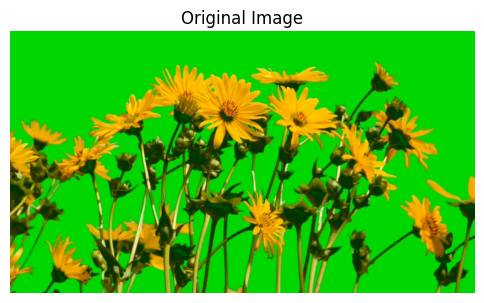

In [27]:
from google.colab import drive
drive.mount('/content/drive')

image_path = "/content/drive/MyDrive/CV-Spring-2026/lab5/images/flower.jpg"

image = cv2.imread(image_path)

if image is None:
    print("Error: Image not found. Check the path.")
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

#Task 1. K-means segmentation in Color Space

In [28]:
#reshaping image
h, w, c = image.shape
pixels = image.reshape((-1, 3))
pixels = np.float32(pixels)


K = 2
Cluster Centers:
[[132 123   9]
 [  3 208   0]]

K = 4
Cluster Centers:
[[115 131  11]
 [  2 211   0]
 [224 172  15]
 [ 29  65   1]]

K = 8
Cluster Centers:
[[ 80  88   3]
 [  0 214   0]
 [241 178   4]
 [128 145  16]
 [ 19  58   0]
 [196 145   6]
 [195 200  90]
 [ 36 166   6]]


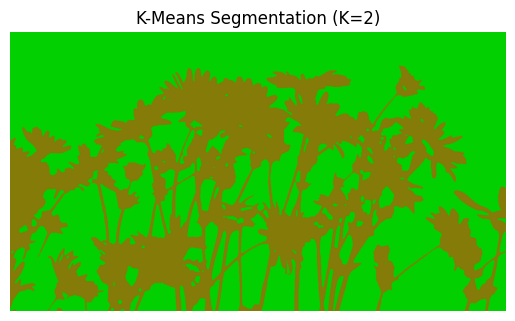

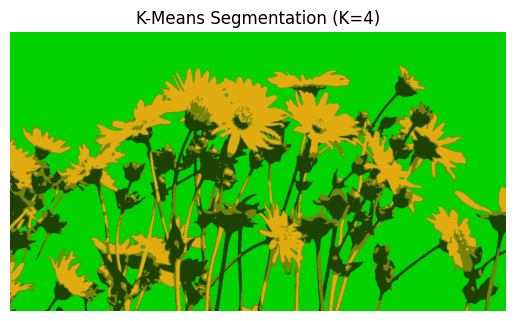

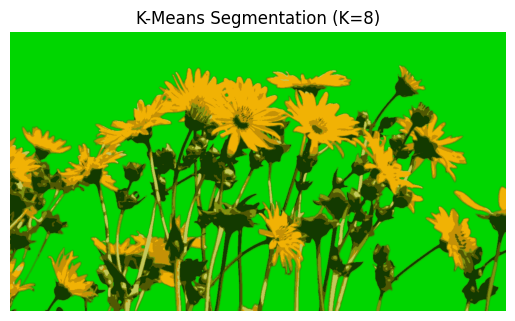

In [29]:
#applying k-means for different k
K_values = [2, 4, 8]

for K in K_values:
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(pixels)

    centers = np.uint8(kmeans.cluster_centers_)
    labels = kmeans.labels_

    segmented = centers[labels.flatten()]
    segmented_image = segmented.reshape((h, w, 3))

    print(f"\nK = {K}")
    print("Cluster Centers:")
    print(centers)

    plt.figure()
    plt.imshow(segmented_image)
    plt.title(f"K-Means Segmentation (K={K})")
    plt.axis("off")

#Task 2. Color space based segmentation

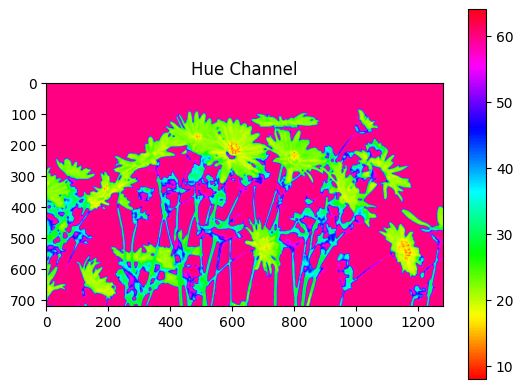

In [30]:
#converting to hsv
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
hue = hsv[:, :, 0]

plt.imshow(hue, cmap="hsv")
plt.title("Hue Channel")
plt.colorbar()
plt.show()

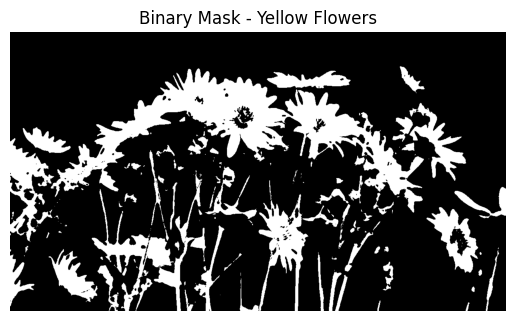

Selected Hue range: 18 - 35
Number of segmented pixels: 200439


In [31]:
lower = 18
upper = 35

mask = cv2.inRange(hsv, (lower, 80, 80), (upper, 255, 255))

plt.imshow(mask, cmap="gray")
plt.title("Binary Mask - Yellow Flowers")
plt.axis("off")
plt.show()

pixel_count = np.sum(mask > 0)
print("Selected Hue range:", lower, "-", upper)
print("Number of segmented pixels:", pixel_count)

In [32]:
#printing statistics
pixel_count = np.sum(mask > 0)
print(f"Selected Hue range: [{lower}-{upper}]")
print(f"Number of segmented pixels: {pixel_count}")

Selected Hue range: [18-35]
Number of segmented pixels: 200439


#Task 3. Region based segmentation using watershed

(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

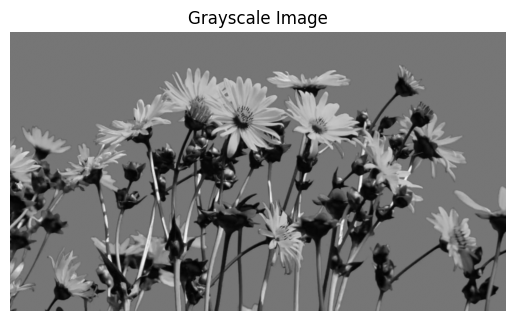

In [33]:
#converting to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap="gray")
plt.title("Grayscale Image")
plt.axis("off")

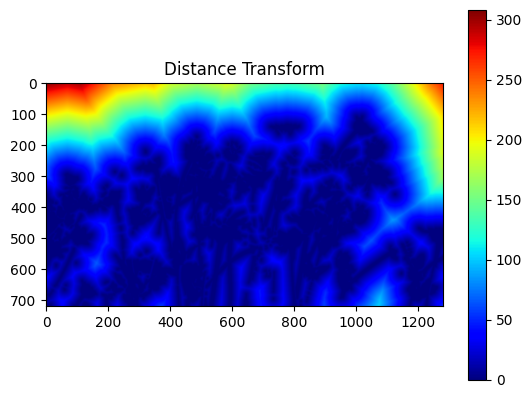

In [34]:
#distance transform
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
distance = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

plt.imshow(distance, cmap="jet")
plt.title("Distance Transform")
plt.colorbar()
plt.show()

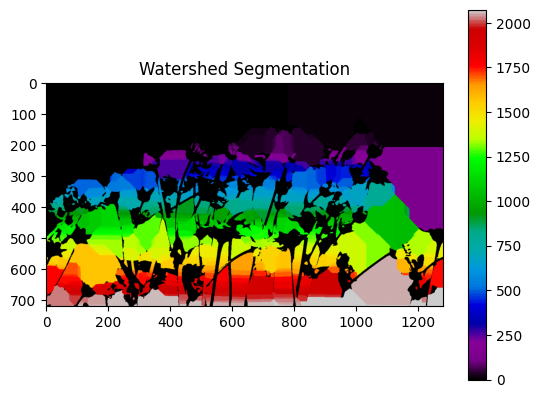

Number of segmented regions: 2074


In [35]:
# Find local maxima coordinates
coords = peak_local_max(distance, footprint=np.ones((3,3)), labels=thresh)

# Create empty marker image
local_max = np.zeros_like(distance, dtype=bool)

# Set local maxima positions to True
local_max[tuple(coords.T)] = True

# Label connected components to create markers
markers = ndi.label(local_max)[0]

# Apply watershed
labels_ws = watershed(-distance, markers, mask=thresh)

# Display result
plt.imshow(labels_ws, cmap="nipy_spectral")
plt.title("Watershed Segmentation")
plt.colorbar()
plt.show()

# Count regions
num_regions = len(np.unique(labels_ws))
print("Number of segmented regions:", num_regions)

#Task 4. Superpixel segmentation

Number of superpixels: 152


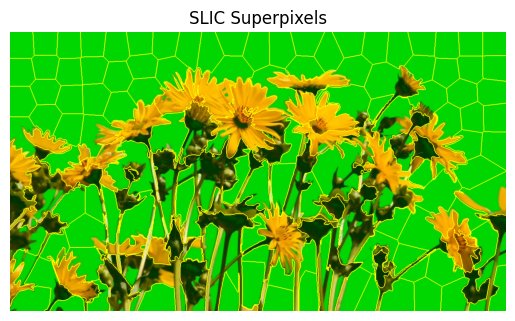

In [36]:
# n_segments defines the approximate number of superpixels, compactness controls the trade-off between color similarity and spatial proximity
segments = slic(image, n_segments=250, compactness=10, start_label=1)

# Visualize superpixel boundaries over the original image
plt.imshow(mark_boundaries(image, segments))
plt.title("SLIC Superpixels")
plt.axis("off")

# Count the number of generated superpixels
num_superpixels = len(np.unique(segments))
print("Number of superpixels:", num_superpixels)

#Task 5. Segmentation result comparison

(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

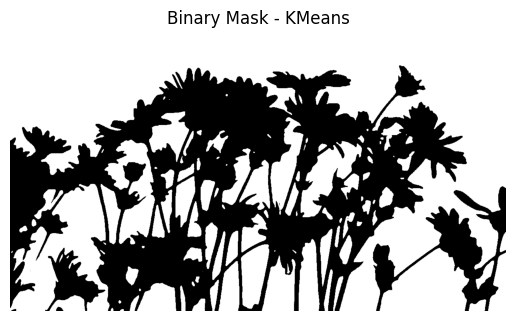

In [37]:
#binary mask from k-means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pixels)

labels = kmeans.labels_.reshape((h, w))

# Choose cluster manually (example: cluster 1)
binary_kmeans = (labels == 1).astype(np.uint8) * 255

plt.imshow(binary_kmeans, cmap="gray")
plt.title("Binary Mask - KMeans")
plt.axis("off")

(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

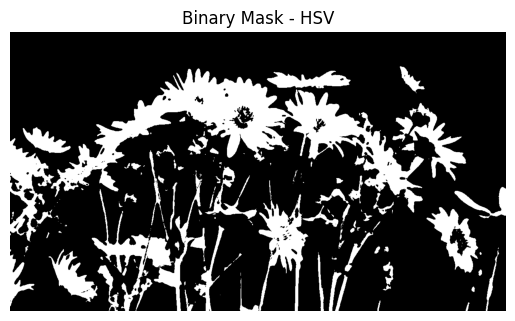

In [38]:
#binary mask from HSV
plt.imshow(mask, cmap="gray")
plt.title("Binary Mask - HSV")
plt.axis("off")